В данном проекте необходимо было сделать следующее:

Создать автокодировщик, удаляющий черные квадраты в случайных областях изображений.

Алгоритм действий:
1. Возьмем базу картинок Mnist.
2. На картинках в случайных местах сделаем чёрные квадраты размера 8 на 8.
3. Создадим и обучим автокодировщик восстанавливать оригинальные изображения из "зашумленных" квадратом изображений.
4. Постараемся добиться MSE < 0.0070 на тестовой выборке

## Импорт библиотек

In [45]:
# Отображение
import matplotlib.pyplot as plt

# Для работы с тензорами
import numpy as np 

# Работа с таблицами
import pandas as pd

# Класс создания модели
from tensorflow.keras.models import Model

# Для загрузки данных
from tensorflow.keras.datasets import mnist

# Необходимые слои
from tensorflow.keras.layers import Input, Conv2DTranspose, MaxPooling2D, Conv2D, BatchNormalization

# Оптимизатор
from tensorflow.keras.optimizers import Adam

from PIL import Image, ImageDraw, ImageFont, ImageFilter
from random import randint, seed

# Отрисовка изображения
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt

# Функции операционной системы
import os

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Загрузка сохраненной модели
from tensorflow.keras.models import load_model

## Данные

In [46]:
# Загрузка данных
(X_train, y_train), (X_test, y_test) = mnist.load_data() 

In [47]:
# Нормировка данных
X_train = X_train.astype('float32')/255.
X_test = X_test.astype('float32')/255.

In [48]:
X_train.shape

(60000, 28, 28)

In [49]:
# Изменение формы под удобную для Keras
X_train = X_train.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

In [50]:
X_train.shape

(60000, 28, 28, 1)

## Автокодировщик

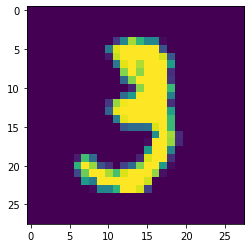

In [52]:
plt.imshow(X_train[10].reshape(28,28))

In [53]:
# создадим новую выборку изображений с рандомным черным квадратом на них, которую впоследствие используем как обучающую
X_train_mod=[]
for img in X_train:
  size = 8
  x0 = np.random.randint(0, 28 - size, 1)[0]
  y0 = np.random.randint(0, 28 - size, 1)[0]
  #img[x0:x0+size, y0:y0+size] = 0
  new = img.copy()
  new[x0:x0+size, y0:y0+size] = 0
  X_train_mod.append(new)

  #new=img[x0:x0+size, y0:y0+size]


In [54]:
X_train_mod = np.array(X_train_mod)
X_train_mod.shape

(60000, 28, 28, 1)

In [55]:
example=X_train_mod[10].reshape(28,28)

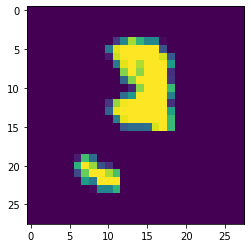

In [56]:
# посмотрим на результат. Видно наличие черного квадрата, который частично перекрывает цифру 3
plt.imshow(example)

Создадим и обучим автокодировщик восстанавливать оригинальные изображения из "зашумленных" квадратом изображений. 

In [57]:
# Функция сборки свёрточного автокодировщика
def create_base_ae(in_shape):

  # Входной слой 
  inputs = Input(in_shape)

  # Энкодер
  # ---------------------------------------------------------------

  # 3 блока свертки перед сжатием 
  x = Conv2D(12, 3, padding='same', activation='relu')(inputs)
  x = BatchNormalization()(x)

  # используем разрежение (dilation_rate) для выявления мелких деталей изображения
  x = Conv2D(24, 3, dilation_rate=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(48, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # Сжатие 1
  x = Conv2D(96, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(96, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # Сжатие 2
  x = Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(256, 3, padding='same', activation='relu')(x)

  # Скрытое пространство
  z = BatchNormalization()(x)

  # Декодер
  # ---------------------------------------------------------------
  # Расширение 2
  x = Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(z)
  x = BatchNormalization()(x)

  x = Conv2D(128, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # Расширение 1
  x = Conv2DTranspose(96, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(48, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(24, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(8, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # финальный слой свертки, выход модели
  outputs = Conv2D(1, 2, dilation_rate=2, padding='same', activation='sigmoid')(x)

  # Сборка модели. На входе оригинальное изображение, на выходе - сжатое-восстановленное
  model = Model(inputs, outputs)

  # компиляция модели
  model.compile(optimizer=Adam(1e-4),
                loss='mse')

  return model

In [58]:
# Настройка констант
IMG_HEIGHT = 28                          # Высота изображений
IMG_WIDTH = 28                            # Ширина избражений
VAL_SPLIT = 0.15                          # Доля проверочной выборки от основного набора

In [59]:
# Создание автокодировщика
ae_mnist = create_base_ae(X_train_mod.shape[1:])

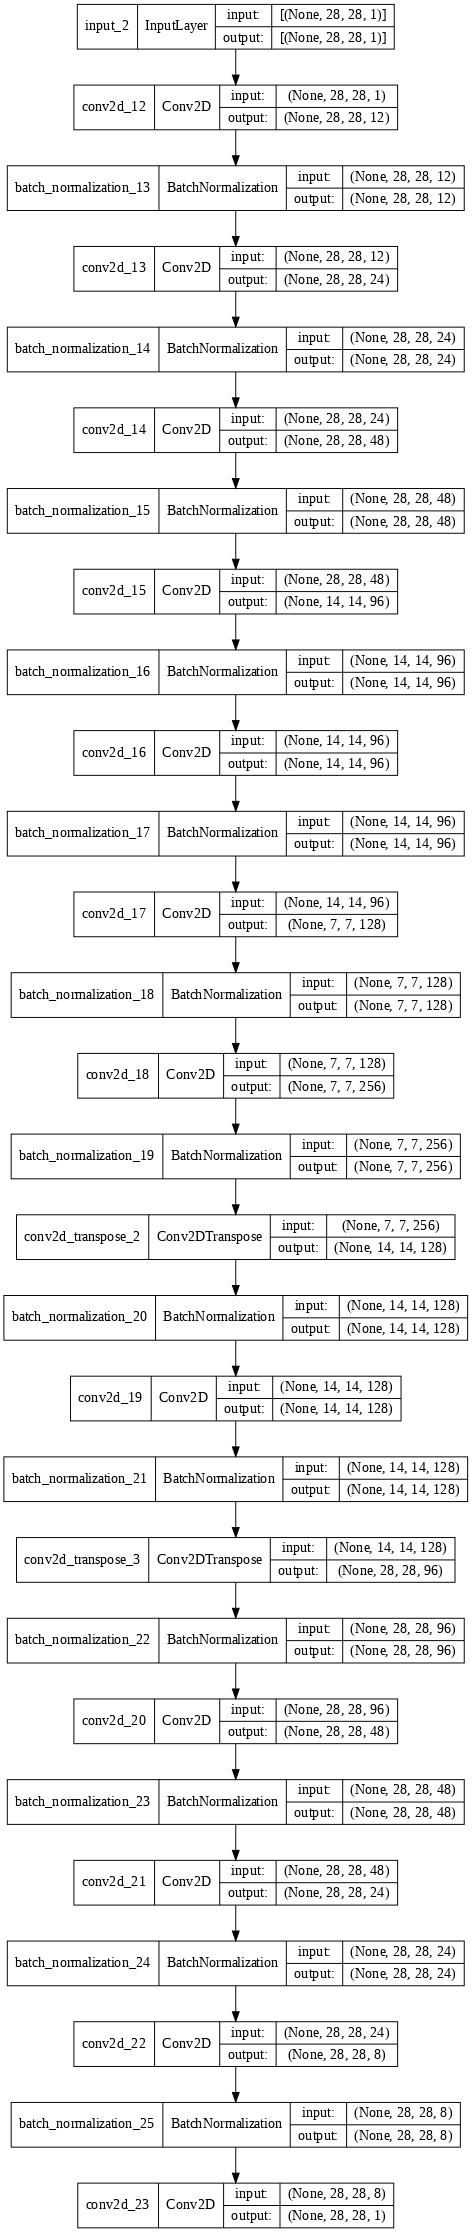

In [60]:
# Отображение модели
utils.plot_model(ae_mnist, show_shapes=True, dpi=70)

In [61]:
ae_mnist.fit(X_train_mod, X_train,
             epochs=10, 
             batch_size=256,
             validation_split=0.15)

Epoch 1/10
200/200 [==============================] - 47s 224ms/step - loss: 0.1043 - val_loss: 0.1219
Epoch 2/10
200/200 [==============================] - 45s 226ms/step - loss: 0.0491 - val_loss: 0.0601
Epoch 3/10
200/200 [==============================] - 45s 226ms/step - loss: 0.0323 - val_loss: 0.0250
Epoch 4/10
200/200 [==============================] - 45s 226ms/step - loss: 0.0239 - val_loss: 0.0195
Epoch 5/10
200/200 [==============================] - 45s 226ms/step - loss: 0.0186 - val_loss: 0.0166
Epoch 6/10
200/200 [==============================] - 45s 226ms/step - loss: 0.0149 - val_loss: 0.0129
Epoch 7/10
200/200 [==============================] - 45s 226ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 8/10
200/200 [==============================] - 45s 226ms/step - loss: 0.0103 - val_loss: 0.0096
Epoch 9/10
200/200 [==============================] - 45s 226ms/step - loss: 0.0089 - val_loss: 0.0085
Epoch 10/10
200/200 [==============================] - 45s 226ms/step - l

In [71]:
ae_mnist.fit(X_train_mod, X_train,
             epochs=5, 
             batch_size=256,
             validation_split=0.15)

Epoch 1/5
200/200 [==============================] - 49s 228ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 2/5
200/200 [==============================] - 45s 227ms/step - loss: 0.0055 - val_loss: 0.0058
Epoch 3/5
200/200 [==============================] - 45s 227ms/step - loss: 0.0049 - val_loss: 0.0053
Epoch 4/5
200/200 [==============================] - 45s 226ms/step - loss: 0.0044 - val_loss: 0.0050
Epoch 5/5
200/200 [==============================] - 45s 225ms/step - loss: 0.0041 - val_loss: 0.0049


Модель отлично обучилась! По уровню ошибки mse мы достигли установленной в задании цели

In [72]:
# Путь к папке для хранения моделей
PATH = '/content/my_ae_models'

# Создадим папку для моделей, если её еще нет
if not os.path.isdir(PATH):
  os.mkdir(PATH)

In [73]:
# Сохранение/восстановление всей модели
ae_mnist.save(PATH + 'ae_mnist') # Сохраняем модель
ae_mnist = load_model(PATH + 'ae_mnist') # Загружаем модель

INFO:tensorflow:Assets written to: /content/my_ae_modelsae_mnist/assets


посмотрим, как предсказывает модель на тестовой выборке

In [74]:
X_test_mod=[]
for img in X_test:
  size = 8
  x0 = np.random.randint(0, 28 - size, 1)[0]
  y0 = np.random.randint(0, 28 - size, 1)[0]
  #img[x0:x0+size, y0:y0+size] = 0
  new = img.copy()
  new[x0:x0+size, y0:y0+size] = 0
  X_test_mod.append(new)

In [75]:
X_test_mod = np.array(X_test_mod)
X_test_mod.shape

(10000, 28, 28, 1)

In [76]:
# Получение предсказания автокодировщика на тестовой выборке
pred = ae_mnist.predict(X_test_mod)

In [77]:
# Функция последовательного вывода нескольких изображений для сравнения
def plot_images(target_images, noised_images, pred, shape=None, n=4): 
    if shape is None:                               # Автоопределение формы данных
        shape = target_images.shape[1:3]                   # форма изображения 

    plt.figure(figsize=(n*4, n*4), dpi=100)                     # Размер полотна
    plt.subplots_adjust(hspace=0.2, wspace=0.001)

    for i in range(0, n):                              # Повтор n раз:
        index = np.random.randint(0, pred.shape[0]) # Выбор случайного индекса 

        # Показ картинки с индексом index из оригинального набора
        ax = plt.subplot(n, 4, 4*i + 1)               # Картинка располагается в верхнем ряду
        plt.imshow(target_images[index].reshape(shape), cmap='gray')
        ax.get_xaxis().set_visible(False) 
        ax.get_yaxis().set_visible(False)
        ax.set_title('Оригинал')

        # Показ шумовой картинки с тем же индексом
        ax = plt.subplot(n, 4, 4*i + 2)           # Картинка располагается в среднем ряду
        plt.imshow(noised_images[index].reshape(shape), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Зашумлённое изображение')

        # Показ картинки с тем же индексом из предсказания автокодировщика
        ax = plt.subplot(n, 4, 4*i + 3)           # Картинка располагается в нижнем ряду
        plt.imshow(pred[index].reshape(shape), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Предсказание')

        # Показ разницы предсказания и зашумленной картинки
        ax = plt.subplot(n, 4, 4*i + 4)           # Картинка располагается в нижнем ряду
        plt.imshow(noised_images[index].reshape(shape) - pred[index].reshape(shape),
                   cmap='gray', vmin=0, vmax=1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Извлечённый шум')
    
    plt.show()

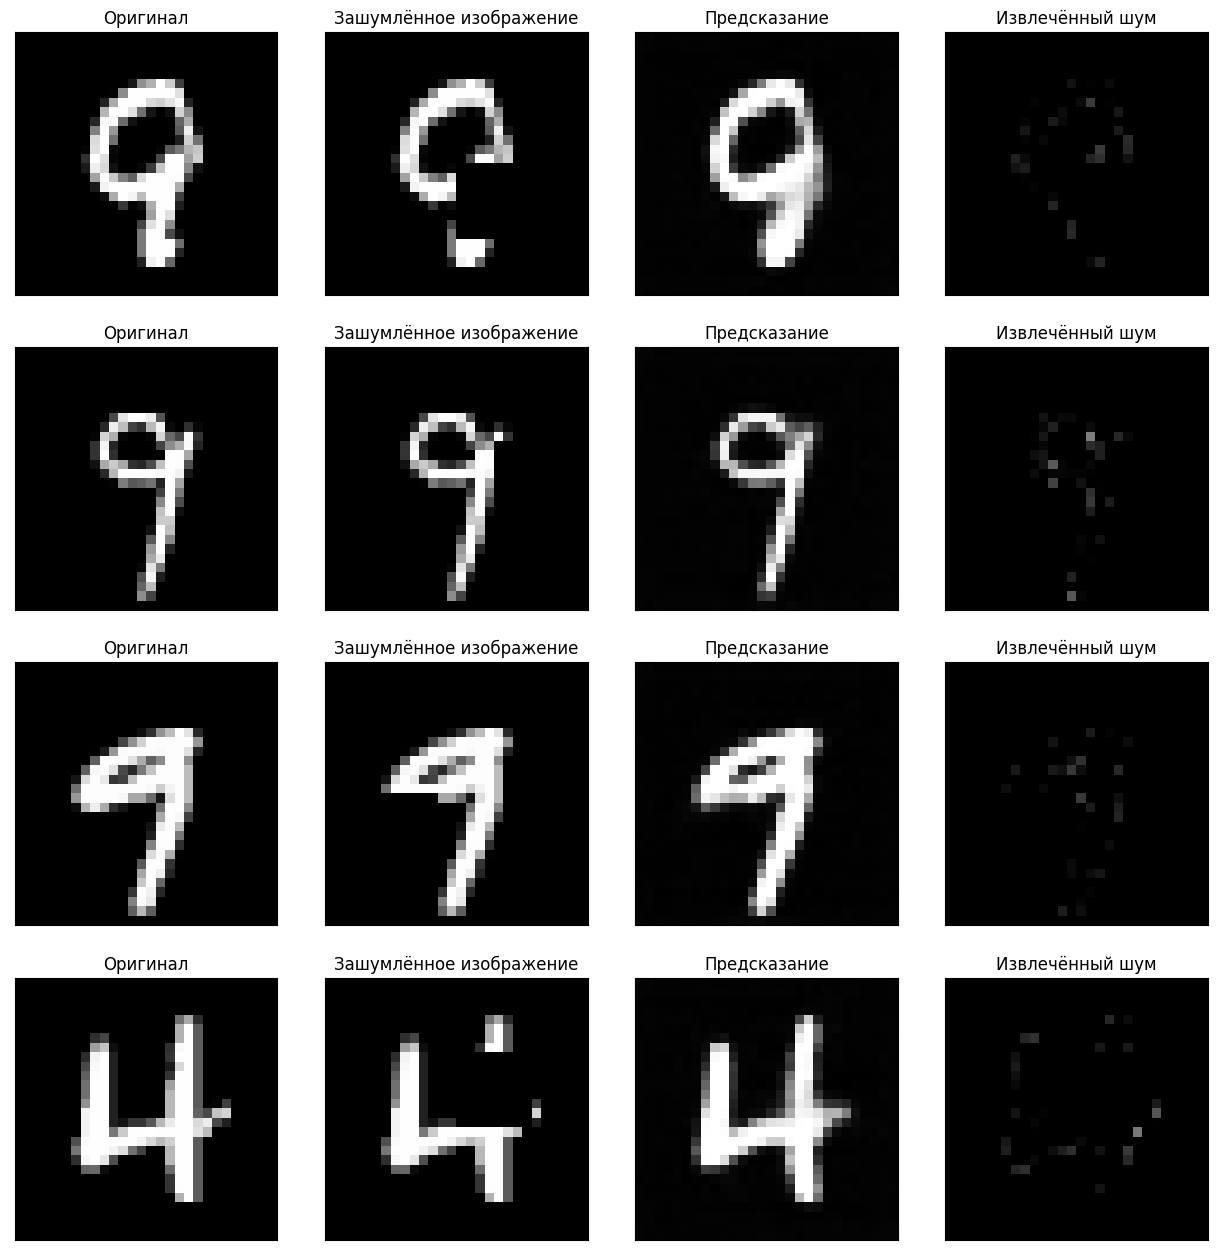

In [78]:
# Сравнение исходных и восстановленных картинок из обучающей выборки
plot_images(X_test, X_test_mod, pred)

In [86]:
# посмотрим, какова будет лосс на тестовых данных, которые модель еще не видела:
eval = ae_mnist.evaluate(X_test_mod, X_test, batch_size=1)

10000/10000 [==============================] - 74s 7ms/step - loss: 0.0048


Итак, нам удалось достичь необходимого уровня mse. На примерах можно увидеть, что модель действительно научилась восстанавливать зашумленные данные - предсказания на самом деле очень похожи на оригинальное изображение. все получилось! Ура!